In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
from itertools import chain
import geoplot
import shapely
import gstools as gs
import numpy as np
import matplotlib.patches as mpatches
import os

In [23]:
global_or_US = "global"
growth_df_global = gpd.GeoDataFrame(
    pd.read_pickle(
        "seaweed_growth_rate_clustered_" + global_or_US + ".pkl"
    )
)

In [24]:
growth_df_global

months_since_war             -3        -2            -1             0  \
-78.152090 194.562505  0.000011  0.000007  1.080906e-06  4.340751e-08   
           195.687505  0.000014  0.000011  1.888677e-06  5.606738e-08   
           196.812505  0.000015  0.000012  2.335622e-06  5.815494e-08   
           197.937506  0.000016  0.000012  2.053414e-06  4.234192e-08   
           320.562509  0.000002  0.000001  9.279054e-08  1.242968e-10   
...                         ...       ...           ...           ...   
 89.616591 183.608458  0.000000  0.000000  2.971729e-10  9.621325e-09   
 89.663855 334.470704  0.000000  0.000000  3.767500e-10  1.093077e-08   
           305.529436  0.000000  0.000000  3.742607e-10  1.071672e-08   
 89.706409 122.527067  0.000000  0.000000  3.408817e-10  9.886951e-09   
 89.706410 157.472790  0.000000  0.000000  3.198583e-10  9.654595e-09   

months_since_war                  1             2             3             4  \
-78.152090 194.562505  0.000000e+00  0.000000e+00  0.000000e+00  2.872584e-11   
           195.687505  0.000000e+00  0.000000e+00  0.000000e+00  4.123149e-11   
           196.812505  0.000000e+00  0.000000e+00  0.000000e+00  5.187178e-11   
           197.937506  0.000000e+00  0.000000e+00  0.000000e+00  1.473226e-10   
           320.562509  0.000000e+00  0.000000e+00  0.000000e+00  1.713758e-14   
...                             ...           ...           ...           ...   
 89.616591 183.608458  4.000441e-08  4.860006e-11  3.434996e-11  8.758652e-12   
 89.663855 334.470704  4.828565e-08  5.368022e-11  5.413988e-11  1.067863e-11   
           305.529436  4.775904e-08  5.703088e-11  4.555200e-11  9.286521e-12   
 89.706409 122.527067  4.042983e-08  4.184417e-11  3.622149e-11  1.025945e-11   
 89.706410 157.472790  3.972105e-08  4.692853e-11  3.334951e-11  9.374161e-12   

months_since_war                  5             6  ...           108  \
-78.152090 194.562505  1.656558e-08  3.199722e-07  ...  7.684799e-09   
           195.687505  2.117739e-08  3.625968e-07  ...  1.514082e-08   
           196.812505  2.318916e-08  3.446465e-07  ...  1.910014e-08   
           197.937506  2.577637e-08  3.659875e-07  ...  1.740600e-08   
           320.562509  9.819242e-13  1.167511e-11  ...  1.843058e-10   
...                             ...           ...  ...           ...   
 89.616591 183.608458  3.237654e-13  0.000000e+00  ...  1.391816e-08   
 89.663855 334.470704  3.672863e-13  0.000000e+00  ...  1.612717e-08   
           305.529436  3.346805e-13  0.000000e+00  ...  1.590135e-08   
 89.706409 122.527067  4.290349e-13  0.000000e+00  ...  1.431736e-08   
 89.706410 157.472790  3.882104e-13  0.000000e+00  ...  1.410699e-08   

months_since_war                109           110           111           112  \
-78.152090 194.562505  0.000000e+00  0.000000e+00  0.000000e+00  1.695093e-11   
           195.687505  0.000000e+00  0.000000e+00  0.000000e+00  4.782390e-11   
           196.812505  0.000000e+00  0.000000e+00  0.000000e+00  1.223867e-10   
           197.937506  0.000000e+00  0.000000e+00  0.000000e+00  2.909292e-10   
           320.562509  0.000000e+00  0.000000e+00  0.000000e+00  1.436959e-12   
...                             ...           ...           ...           ...   
 89.616591 183.608458  1.329644e-07  3.530576e-07  3.399879e-07  2.898518e-07   
 89.663855 334.470704  1.454482e-07  3.631096e-07  2.506540e-07  3.870041e-07   
           305.529436  1.445498e-07  3.696052e-07  2.706320e-07  3.848347e-07   
 89.706409 122.527067  1.356530e-07  3.430645e-07  2.930233e-07  2.997041e-07   
 89.706410 157.472790  1.347699e-07  3.453279e-07  3.142684e-07  2.971347e-07   

months_since_war                113           114           115           116  \
-78.152090 194.562505  4.333771e-08  1.198245e-06  9.928892e-06  5.656922e-05   
           195.687505  6.924070e-08  1.572849e-06  1.059330e-05  6.042587e-05   
           196.812505  6.846431e-08  1.584246e-06  1.071534e-05  6.37

In [25]:
def prepare_geometry(growth_df):
    """
    Prepares the geometry for the growth_df. For some reason the spatial data has
    a longitude that is 0-360 instead of -180 to 180. This function converts it to
    the latter
    """
    growth_df["latlon"] = growth_df.index
    growth_df["latitude"] = growth_df["latlon"].str[0]
    growth_df["longitude"] = growth_df["latlon"].str[1]
    growth_df["longitude"] = growth_df[growth_df["longitude"] > 180]["longitude"] - 360
    growth_df["geometry"] = growth_df[["longitude", "latitude"]].apply(tuple, axis=1)
    growth_df["geometry"] = growth_df["geometry"].apply(Point)
    growth_df = growth_df[["cluster", "geometry"]]
    growth_df = gpd.GeoDataFrame(growth_df)
    return growth_df

In [32]:
tail = growth_df_global.tail()
tail

months_since_war       -3   -2            -1             0             1  \
89.616591 183.608458  0.0  0.0  2.971729e-10  9.621325e-09  4.000441e-08   
89.663855 334.470704  0.0  0.0  3.767500e-10  1.093077e-08  4.828565e-08   
          305.529436  0.0  0.0  3.742607e-10  1.071672e-08  4.775904e-08   
89.706409 122.527067  0.0  0.0  3.408817e-10  9.886951e-09  4.042983e-08   
89.706410 157.472790  0.0  0.0  3.198583e-10  9.654595e-09  3.972105e-08   

months_since_war                 2             3             4             5  \
89.616591 183.608458  4.860006e-11  3.434996e-11  8.758652e-12  3.237654e-13   
89.663855 334.470704  5.368022e-11  5.413988e-11  1.067863e-11  3.672863e-13   
          305.529436  5.703088e-11  4.555200e-11  9.286521e-12  3.346805e-13   
89.706409 122.527067  4.184417e-11  3.622149e-11  1.025945e-11  4.290349e-13   
89.706410 157.472790  4.692853e-11  3.334951e-11  9.374161e-12  3.882104e-13   

months_since_war        6  ...           108           109           110  \
89.616591 183.608458  0.0  ...  1.391816e-08  1.329644e-07  3.530576e-07   
89.663855 334.470704  0.0  ...  1.612717e-08  1.454482e-07  3.631096e-07   
          305.529436  0.0  ...  1.590135e-08  1.445498e-07  3.696052e-07   
89.706409 122.527067  0.0  ...  1.431736e-08  1.356530e-07  3.430645e-07   
89.706410 157.472790  0.0  ...  1.410699e-08  1.347699e-07  3.453279e-07   

months_since_war               111           112           113  114  115  116  \
89.616591 183.608458  3.399879e-07  2.898518e-07  6.046378e-08  0.0  0.0  0.0   
89.663855 334.470704  2.506540e-07  3.870041e-07  6.417316e-08  0.0  0.0  0.0   
          305.529436  2.706320e-07  3.848347e-07  6.888572e-08  0.0  0.0  0.0   
89.706409 122.527067  2.930233e-07  2.997041e-07  6.003690e-08  0.0  0.0  0.0   
89.706410 157.472790  3.142684e-07  2.971347e-07  6.233629e-08  0.0  0.0  0.0   

months_since_war      cluster  
89.616591 183.608458        0  
89.663855 334.470704        0  
          305.529436        0  
89.706409 122.527067        0  
89.706410 157.472790        0  

[5 rows x 121 columns]

In [33]:
tail["latlon"] = tail.index
tail

/tmp/ipykernel_9151/1958964125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail["latlon"] = tail.index


months_since_war       -3   -2            -1             0             1  \
89.616591 183.608458  0.0  0.0  2.971729e-10  9.621325e-09  4.000441e-08   
89.663855 334.470704  0.0  0.0  3.767500e-10  1.093077e-08  4.828565e-08   
          305.529436  0.0  0.0  3.742607e-10  1.071672e-08  4.775904e-08   
89.706409 122.527067  0.0  0.0  3.408817e-10  9.886951e-09  4.042983e-08   
89.706410 157.472790  0.0  0.0  3.198583e-10  9.654595e-09  3.972105e-08   

months_since_war                 2             3             4             5  \
89.616591 183.608458  4.860006e-11  3.434996e-11  8.758652e-12  3.237654e-13   
89.663855 334.470704  5.368022e-11  5.413988e-11  1.067863e-11  3.672863e-13   
          305.529436  5.703088e-11  4.555200e-11  9.286521e-12  3.346805e-13   
89.706409 122.527067  4.184417e-11  3.622149e-11  1.025945e-11  4.290349e-13   
89.706410 157.472790  4.692853e-11  3.334951e-11  9.374161e-12  3.882104e-13   

months_since_war        6  ...           109           110           111  \
89.616591 183.608458  0.0  ...  1.329644e-07  3.530576e-07  3.399879e-07   
89.663855 334.470704  0.0  ...  1.454482e-07  3.631096e-07  2.506540e-07   
          305.529436  0.0  ...  1.445498e-07  3.696052e-07  2.706320e-07   
89.706409 122.527067  0.0  ...  1.356530e-07  3.430645e-07  2.930233e-07   
89.706410 157.472790  0.0  ...  1.347699e-07  3.453279e-07  3.142684e-07   

months_since_war               112           113  114  115  116  cluster  \
89.616591 183.608458  2.898518e-07  6.046378e-08  0.0  0.0  0.0        0   
89.663855 334.470704  3.870041e-07  6.417316e-08  0.0  0.0  0.0        0   
          305.529436  3.848347e-07  6.888572e-08  0.0  0.0  0.0        0   
89.706409 122.527067  2.997041e-07  6.003690e-08  0.0  0.0  0.0        0   
89.706410 157.472790  2.971347e-07  6.233629e-08  0.0  0.0  0.0        0   

months_since_war                                       latlon  
89.616591 183.608458  (89.61659137538058, 183.60845808023402)  
89.663855 334.470704   (89.66385504535485, 334.4707044806696)  
          305.529436   (89.66385523928798, 305.5294362872482)  
89.706409 122.527067   (89.70640939822049, 122.5270667918693)  
89.706410 157.472790   (89.70640964187461, 157.4727899369786)  

[5 rows x 122 columns]

In [34]:
tail["latitude"] = tail["latlon"].str[0]
tail["longitude"] = tail["latlon"].str[1]
tail

/tmp/ipykernel_9151/1142720423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail["latitude"] = tail["latlon"].str[0]
/tmp/ipykernel_9151/1142720423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail["longitude"] = tail["latlon"].str[1]


months_since_war       -3   -2            -1             0             1  \
89.616591 183.608458  0.0  0.0  2.971729e-10  9.621325e-09  4.000441e-08   
89.663855 334.470704  0.0  0.0  3.767500e-10  1.093077e-08  4.828565e-08   
          305.529436  0.0  0.0  3.742607e-10  1.071672e-08  4.775904e-08   
89.706409 122.527067  0.0  0.0  3.408817e-10  9.886951e-09  4.042983e-08   
89.706410 157.472790  0.0  0.0  3.198583e-10  9.654595e-09  3.972105e-08   

months_since_war                 2             3             4             5  \
89.616591 183.608458  4.860006e-11  3.434996e-11  8.758652e-12  3.237654e-13   
89.663855 334.470704  5.368022e-11  5.413988e-11  1.067863e-11  3.672863e-13   
          305.529436  5.703088e-11  4.555200e-11  9.286521e-12  3.346805e-13   
89.706409 122.527067  4.184417e-11  3.622149e-11  1.025945e-11  4.290349e-13   
89.706410 157.472790  4.692853e-11  3.334951e-11  9.374161e-12  3.882104e-13   

months_since_war        6  ...           111           112           113  114  \
89.616591 183.608458  0.0  ...  3.399879e-07  2.898518e-07  6.046378e-08  0.0   
89.663855 334.470704  0.0  ...  2.506540e-07  3.870041e-07  6.417316e-08  0.0   
          305.529436  0.0  ...  2.706320e-07  3.848347e-07  6.888572e-08  0.0   
89.706409 122.527067  0.0  ...  2.930233e-07  2.997041e-07  6.003690e-08  0.0   
89.706410 157.472790  0.0  ...  3.142684e-07  2.971347e-07  6.233629e-08  0.0   

months_since_war      115  116  cluster  \
89.616591 183.608458  0.0  0.0        0   
89.663855 334.470704  0.0  0.0        0   
          305.529436  0.0  0.0        0   
89.706409 122.527067  0.0  0.0        0   
89.706410 157.472790  0.0  0.0        0   

months_since_war                                       latlon   latitude  \
89.616591 183.608458  (89.61659137538058, 183.60845808023402)  89.616591   
89.663855 334.470704   (89.66385504535485, 334.4707044806696)  89.663855   
          305.529436   (89.66385523928798, 305.5294362872482)  89.663855   
89.706409 122.527067   (89.70640939822049, 122.5270667918693)  89.706409   
89.706410 157.472790   (89.70640964187461, 157.4727899369786)  89.706410   

months_since_war       longitude  
89.616591 183.608458  183.608458  
89.663855 334.470704  334.470704  
          305.529436  305.529436  
89.706409 122.527067  122.527067  
89.706410 157.472790  157.472790  

[5 rows x 124 columns]

In [37]:
tail["longitude"] = tail["longitude"].apply(lambda x: x - 360 if x > 180 else x)
tail


/tmp/ipykernel_9151/1008808626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail["longitude"] = tail["longitude"].apply(lambda x: x - 360 if x > 180 else x)


months_since_war       -3   -2            -1             0             1  \
89.616591 183.608458  0.0  0.0  2.971729e-10  9.621325e-09  4.000441e-08   
89.663855 334.470704  0.0  0.0  3.767500e-10  1.093077e-08  4.828565e-08   
          305.529436  0.0  0.0  3.742607e-10  1.071672e-08  4.775904e-08   
89.706409 122.527067  0.0  0.0  3.408817e-10  9.886951e-09  4.042983e-08   
89.706410 157.472790  0.0  0.0  3.198583e-10  9.654595e-09  3.972105e-08   

months_since_war                 2             3             4             5  \
89.616591 183.608458  4.860006e-11  3.434996e-11  8.758652e-12  3.237654e-13   
89.663855 334.470704  5.368022e-11  5.413988e-11  1.067863e-11  3.672863e-13   
          305.529436  5.703088e-11  4.555200e-11  9.286521e-12  3.346805e-13   
89.706409 122.527067  4.184417e-11  3.622149e-11  1.025945e-11  4.290349e-13   
89.706410 157.472790  4.692853e-11  3.334951e-11  9.374161e-12  3.882104e-13   

months_since_war        6  ...           111           112           113  114  \
89.616591 183.608458  0.0  ...  3.399879e-07  2.898518e-07  6.046378e-08  0.0   
89.663855 334.470704  0.0  ...  2.506540e-07  3.870041e-07  6.417316e-08  0.0   
          305.529436  0.0  ...  2.706320e-07  3.848347e-07  6.888572e-08  0.0   
89.706409 122.527067  0.0  ...  2.930233e-07  2.997041e-07  6.003690e-08  0.0   
89.706410 157.472790  0.0  ...  3.142684e-07  2.971347e-07  6.233629e-08  0.0   

months_since_war      115  116  cluster  \
89.616591 183.608458  0.0  0.0        0   
89.663855 334.470704  0.0  0.0        0   
          305.529436  0.0  0.0        0   
89.706409 122.527067  0.0  0.0        0   
89.706410 157.472790  0.0  0.0        0   

months_since_war                                       latlon   latitude  \
89.616591 183.608458  (89.61659137538058, 183.60845808023402)  89.616591   
89.663855 334.470704   (89.66385504535485, 334.4707044806696)  89.663855   
          305.529436   (89.66385523928798, 305.5294362872482)  89.663855   
89.706409 122.527067   (89.70640939822049, 122.5270667918693)  89.706409   
89.706410 157.472790   (89.70640964187461, 157.4727899369786)  89.706410   

months_since_war       longitude  
89.616591 183.608458 -176.391542  
89.663855 334.470704  -25.529296  
          305.529436  -54.470564  
89.706409 122.527067  122.527067  
89.706410 157.472790  157.472790  

[5 rows x 124 columns]

In [35]:
growth_df = pd.read_pickle("seaweed_growth_rate_US.pkl")
growth_df.head()

,months_since_war,-3,-2,-1,0,1,2,3,4,5,6,...,23,24,25,26,27,28,29,30,31,32
17.474949,296.964984,0.001713,0.002960,0.003273,0.000885,0.001020,0.001169,0.005665,0.033146,0.011555,0.038658,...,0.232085,0.294979,0.256263,0.144956,0.056323,0.014078,0.116878,0.155073,0.154488,0.201556
17.480288,295.841260,0.001554,0.002572,0.002647,0.001243,0.001357,0.001396,0.003503,0.039053,0.010267,0.043849,...,0.244887,0.294930,0.258062,0.129433,0.049293,0.018897,0.130522,0.164956,0.162026,0.214243
17.485865,294.717527,0.007369,0.006435,0.005641,0.002180,0.001755,0.003822,0.015460,0.099150,0.054273,0.076929,...,0.247861,0.297108,0.269469,0.130002,0.055334,0.029291,0.139437,0.161127,0.168939,0.216274
17.491679,293.593785,0.006218,0.007969,0.003646,0.001346,0.001417,0.002631,0.007188,0.078115,0.014350,0.056613,...,0.247415,0.307846,0.274105,0.117155,0.041598,0.007778,0.091717,0.119585,0.155557,0.211258
17.497726,292.470032,0.008501,0.017743,0.008738,0.002157,0.002583,0.003510,0.008523,0.066387,0.009337,0.050040,...,0.249266,0.310948,0.277589,0.124095,0.049967,0.009588,0.080941,0.106471,0.150628,0.211287


In [36]:
growth_df.median().index.to_list()

[-3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

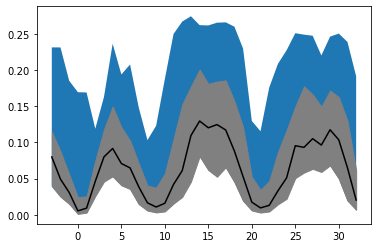

In [37]:
q95=growth_df.quantile(0.90)
q5=growth_df.quantile(0.10)
q32=q5=growth_df.quantile(0.32)
q68=growth_df.quantile(0.68)
plt.fill_between(x=q95.index.to_list(), y1=q5, y2=q95)
plt.fill_between(x=q95.index.to_list(), y1=q32, y2=q68, color="grey")
plt.plot(growth_df.median(), color="black")

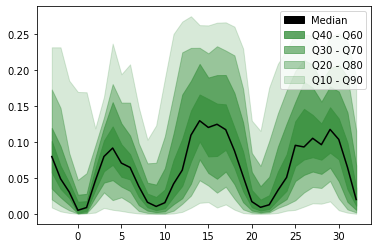

In [38]:
for q in np.arange(0.1,0.6,0.1):
    q_up = growth_df.quantile(1-q)
    q_down = growth_df.quantile(q)
    plt.fill_between(x=q_up.index, y1=q_down, y2=q_up, color="#3A913F", alpha=q*2)
plt.plot(growth_df.median(), color="black")
    
# Create the legend
patches_list=[]
patches_list.append(mpatches.Patch(color="black", label="Median"))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q40 - Q60", alpha=0.8))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q30 - Q70", alpha=0.6))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q20 - Q80", alpha=0.4))
patches_list.append(mpatches.Patch(color="#3A913F", label="Q10 - Q90", alpha=0.2))

plt.legend(handles=patches_list)


In [39]:
growth_df = pd.read_pickle("seaweed_growth_rate_clustered_US.pkl")

# overall mean by cluster
growth_df.groupby("cluster").mean().mean(axis=1)

cluster
0    0.088007
1    0.172486
2    0.071954
3    0.118033
4    0.023120
dtype: float64

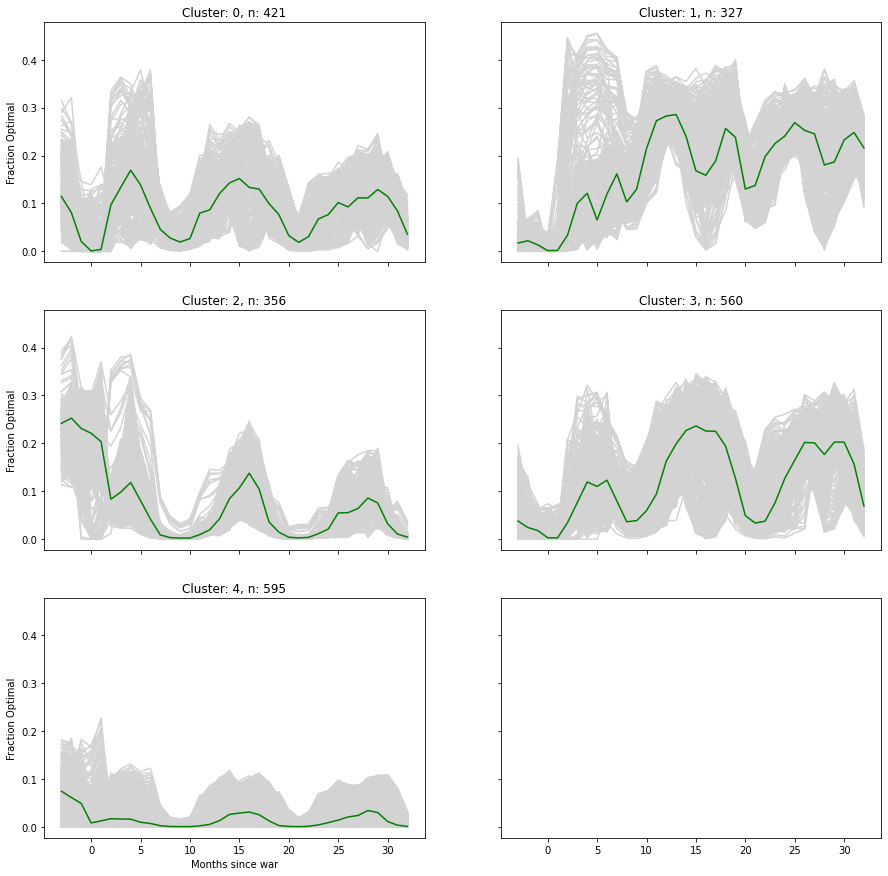

In [40]:
fix, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(15, 15))

axes = axes.flatten()
for cluster, cluster_df in growth_df.groupby("cluster"):
    del(cluster_df["cluster"])
    ax = axes[cluster]
    cluster_df.transpose().plot(ax=ax, color="lightgrey", legend=False)
    cluster_df.median().transpose().plot(ax=ax, color="green", legend=False)
    ax.set_ylabel("Fraction Optimal")
    ax.set_xlabel("Months since war")
    ax.set_title("Cluster: " + str(cluster) + ", n: " + str(cluster_df.shape[0]))

In [41]:
growth_df["latlon"] = growth_df.index
growth_df['latitude'] = growth_df["latlon"].str[0]
growth_df['longitude'] = growth_df['latlon'].str[1]
growth_df['longitude'] = growth_df[growth_df["longitude"]>180]["longitude"] - 360
#print(growth_df.longitude.min())

In [42]:
growth_df["geometry"] = growth_df[['longitude','latitude']].apply(tuple, axis=1)
growth_df["geometry"] = growth_df["geometry"].apply(Point)
growth_df = growth_df[["cluster", "geometry"]]
growth_df = gpd.GeoDataFrame(growth_df)
growth_df.set_crs(epsg=4326).to_file("clusters_shp/clusters.shp")
growth_df

,months_since_war,cluster,geometry
17.474949,296.964984,1,POINT (-63.03502 17.47495)
17.480288,295.841260,1,POINT (-64.15874 17.48029)
17.485865,294.717527,1,POINT (-65.28247 17.48587)
17.491679,293.593785,1,POINT (-66.40622 17.49168)
17.497726,292.470032,1,POINT (-67.52997 17.49773)
...,...,...,...
52.808242,229.511355,4,POINT (-130.48865 52.80824)
52.928145,228.400686,4,POINT (-131.59931 52.92815)
53.342084,229.672963,4,POINT (-130.32704 53.34208)
53.464323,228.563404,4,POINT (-131.43660 53.46432)


In [43]:
buffered = gpd.GeoDataFrame(growth_df.buffer(0.65))
buffered["cluster"] = growth_df["cluster"]
buffered.columns=["geometry", "cluster"]
cluster_dict = {0:"high/low",
               1:"low/medium",
               2:"low/low",
               3:"low/high",
               4:"medium/medium"
               }
buffered["cluster_names"] = buffered["cluster"].map(cluster_dict)


In [44]:
global_map = gpd.read_file("../geospatial_information/Countries/ne_50m_admin_0_countries.shp")


(-130.0, -65.0)

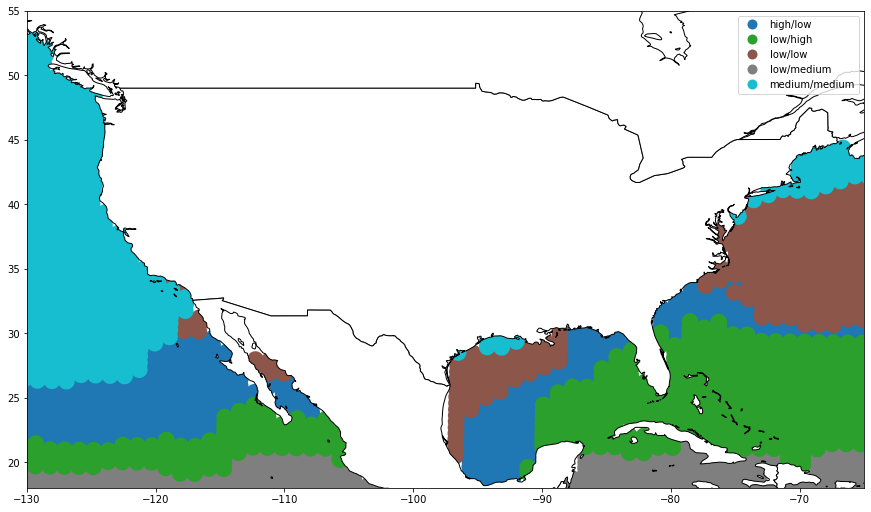

In [45]:
cluster_dissolved = buffered.dissolve(by="cluster")
cluster_dissolved.set_crs(epsg=4326,inplace=True)
cluster_dissolved.to_crs(global_map.crs,inplace=True)
cluster_dissolved["cluster"] = cluster_dissolved.index
ax = cluster_dissolved.plot(column="cluster_names", legend=True)
fig = plt.gcf()
fig.set_size_inches(15,15)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(18,55)
ax.set_xlim(-130,-65)

In [46]:
growth_df

,months_since_war,cluster,geometry
17.474949,296.964984,1,POINT (-63.03502 17.47495)
17.480288,295.841260,1,POINT (-64.15874 17.48029)
17.485865,294.717527,1,POINT (-65.28247 17.48587)
17.491679,293.593785,1,POINT (-66.40622 17.49168)
17.497726,292.470032,1,POINT (-67.52997 17.49773)
...,...,...,...
52.808242,229.511355,4,POINT (-130.48865 52.80824)
52.928145,228.400686,4,POINT (-131.59931 52.92815)
53.342084,229.672963,4,POINT (-130.32704 53.34208)
53.464323,228.563404,4,POINT (-131.43660 53.46432)


In [47]:
growth_df["cluster_names"] = growth_df["cluster"].map(cluster_dict)


In [51]:
eez = gpd.read_file("../geospatial_information/EEZ/eez_boundaries_v11.shp")
eez = eez[eez["SOVEREIGN1"]=="United States"]
eez

,LINE_ID,LINE_NAME,LINE_TYPE,MRGID_SOV1,MRGID_TER1,TERRITORY1,SOVEREIGN1,MRGID_TER2,TERRITORY2,MRGID_SOV2,...,SOURCE2,URL2,SOURCE3,URL3,ORIGIN,DOC_DATE,MRGID_JREG,JOINT_REG,LENGTH_KM,geometry
117,1297.0,American Samoa (United States) - Cook Islands ...,Treaty,2204.0,8670.0,American Samoa,United States,8672.0,Cook Islands,2227.0,...,Treaty between the United States of America an...,http://www.marineregions.org/documents/USA-COK...,None,None,Database,1980-06-11,0.0,None,1036.0,"LINESTRING (-166.64306 -17.55778, -166.02750 -..."
157,1345.0,American Samoa (United States) - Tokelau (New ...,Treaty,2204.0,8670.0,American Samoa,United States,8675.0,Tokelau,2227.0,...,None,None,None,None,Database,1980-12-02,0.0,None,590.0,"LINESTRING (-168.51667 -10.02389, -169.78056 -..."
158,1346.0,American Samoa (United States) - Niue (New Zea...,Treaty,2204.0,8670.0,American Samoa,United States,8673.0,Niue,2227.0,...,None,None,None,None,Database,1997-05-13,0.0,None,517.0,"LINESTRING (-166.64194 -17.55500, -166.66056 -..."
171,1369.0,Puerto Rico (United States) - Venezuela,Treaty,2204.0,8641.0,Puerto Rico,United States,2201.0,Venezuela,2201.0,...,Maritime Boundary: Venezuela - USA,http://www.marineregions.org/documents/ls91.jpg,None,None,Database,1978-03-28,0.0,None,311.0,"LINESTRING (-65.98140 15.65491, -66.11917 15.5..."
221,1886.0,Guam (United States) - Micronesia,Treaty,2204.0,8599.0,Guam,United States,8595.0,Micronesia,8595.0,...,None,None,None,None,Database,2014-08-01,0.0,None,828.0,"LINESTRING (141.21875 13.09764, 141.34719 12.9..."
253,1924.0,Howland and Baker islands (United States) - Ph...,Treaty,2204.0,48684.0,Howland and Baker islands,United States,8658.0,Phoenix Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,613.0,"LINESTRING (-177.45297 -3.01483, -177.28460 -2..."
256,1927.0,Jarvis Island (United States) - Line Group (Ki...,Treaty,2204.0,8668.0,Jarvis Island,United States,8657.0,Line Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,1014.0,"LINESTRING (-158.30397 -3.27175, -158.18572 -3..."
257,1929.0,Palmyra Atoll (United States) - Line Group (Ki...,Treaty,2204.0,8669.0,Palmyra Atoll,United States,8657.0,Line Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,710.0,"LINESTRING (-163.06472 2.65967, -162.18732 3.9..."
285,2067.0,United States Virgin Islands (United States) -...,Treaty,2204.0,8642.0,United States Virgin Islands,United States,2201.0,Venezuela,2201.0,...,Maritime Boundary: Venezuela - USA,http://www.marineregions.org/documents/ls91.jpg,None,None,Database,1978-03-28,0.0,None,243.0,"LINESTRING (-64.01889 16.74694, -64.10861 16.7..."
336,3649.0,Jarvis Island (United States) 200 NM,200 NM,2204.0,8668.0,Jarvis Island,United States,0.0,None,0.0,...,None,None,None,None,Buffer,2017-03-28,0.0,None,1069.0,"LINESTRING (-158.31855 -3.28679, -158.31924 -3..."


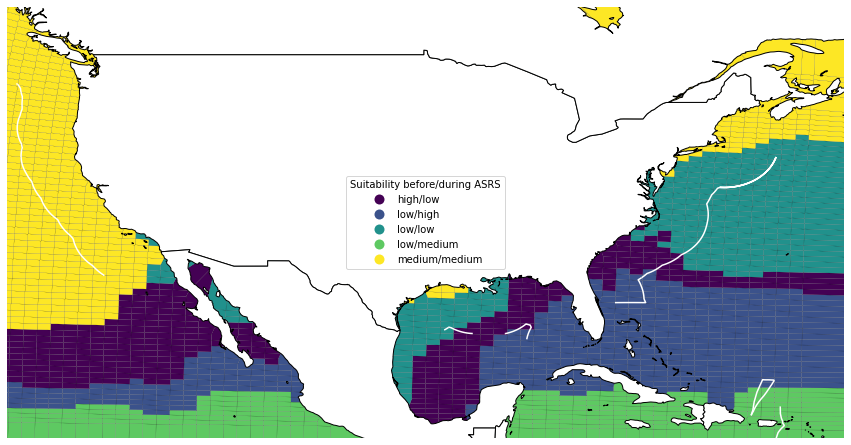

In [52]:
growth_df.set_crs(epsg=4326,inplace=True)
growth_df.to_crs(global_map.crs,inplace=True)
ax = geoplot.voronoi(growth_df, hue="cluster_names", legend=True, linewidth=0.1)
legend = ax.get_legend()
legend.set_title("Suitability before/during ASRS")
legend.set_facecolor="white"
fig = plt.gcf()
fig.set_size_inches(15,15)
eez.to_crs(global_map.crs).plot(ax=ax,facecolor="none", edgecolor='white', lw=1.5)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(17,53)
ax.set_xlim(-130,-60)
plt.savefig("clusters_US.png", dpi=300, bbox_inches="tight")

<AxesSubplot:>

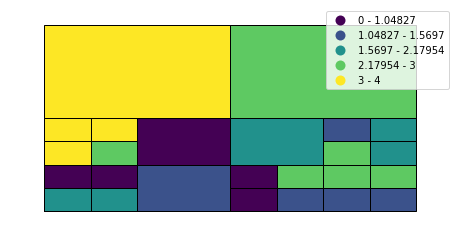

In [59]:
geoplot.quadtree(growth_df, hue="cluster", legend=True, scheme="Quantiles")